In [102]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, KFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.decomposition import PCA
import umap
import json


import scanpy
import anndata
import shap
import xgboost

from tqdm import tqdm

shap.initjs()

for some reason for ML model (trained on Geuvadis-BRAIN0 common transcripts) eval on BRAIN0 has bad quality
![alt text](image.png)

In [103]:

fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'

organ = ['BRAIN0', "HEART", "BRAIN1", 'None'][1]

#! SHOLD BE THE SAME AS IN train_model.py
# feature_importance_method = 'native'
feature_importance_method = 'SHAP'


value_to_predict = 'Sex'

sex = ['chrXY', 'chrX', 'chrY', 'autosome'][3]

In [104]:
with open(f'../models/{model_type}.json', 'r') as file:
    model_params = json.load(file)

if model_type == 'xgboost':
    model = xgb.XGBClassifier(**model_params)

In [105]:

data = pd.read_hdf(fdir_traintest / f'geuvadis.preprocessed.sex.h5', key=sex)


features_fname = f"geuvadis_train_features_{sex}_calibration_{organ}.csv"
features_list = pd.read_csv(ml_models_fdir / model_type / features_fname, index_col=0)

# features = pd.read_hdf(
#     fdir_processed / f'feature_importance.{"xgboost"}.{value_to_predict}.organ_{organ}.h5',
#     key=f'{sex}',
# )

# features = features[feature_importance_method]
# features = features.sort_values(ascending=False)

# if organ != "None":
#     fname = next((fdir_external / organ / 'reg').glob("*processed.h5"))
#     fname = fname.name

#     data_eval_ = pd.read_hdf(fdir_external / organ / 'reg' / fname, index_col=0)
#     features = features.loc[features.index.intersection(data_eval_.columns)]
#     print(features.shape)

# features_list = features

# features_fname = f"geuvadis_features_{sex}_calibration_{organ}.csv"
# features_list.to_csv(ml_models_fdir / model_type / features_fname)

data = data[features_list.index]
# print(features_list)

X_train = data.values

scaler = RobustScaler().fit(X_train)
X_train = scaler.transform(X_train)


data_header = pd.read_hdf(fdir_processed / 'geuvadis.preprocessed.h5', key='header')
y_train = data_header['Sex'].values
# print(y_train)
y_train = LabelEncoder().fit_transform(y_train)

proba = np.zeros(shape=(X_train.shape[0], 2))
pred = np.zeros(shape=(X_train.shape[0]))

mean_fpr = np.linspace(0, 1, 100)
tprs = []
accuracies = []
f1 = []
precisions = []
recalls = []

for i in range(1):
    saved_model_filename = f"geuvadis_fold{i}_{sex}_calibration_{organ}.json"
    model.load_model(fname=ml_models_fdir / model_type / saved_model_filename)

    proba += model.predict_proba(X_train)
    pred_ = model.predict(X_train)
    # if sex == 'autosome':
    #     pred_ = np.abs(pred_ - 1)
    pred += pred_

    accuracies.append(accuracy_score(y_train, pred_))
    f1.append(f1_score(y_train, pred_))
    precisions.append(precision_score(y_train, pred_))
    recalls.append(recall_score(y_train, pred_))

    # viz = RocCurveDisplay.from_predictions(
    #     y, model.predict_proba(X)[:, 1], ax=None
    #     # ax=ax,
    # )
    # interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    # interp_tpr[0] = 0
    # tprs.append(interp_tpr)
    
proba = proba / 5
# # pred = pred / 5
# if sex == 'autosome':
#     print('predicted:   ', (proba[:, 1] > 0.5).astype(int))
# else:
#     print('predicted:   ', (proba[:, 1] > 0.5).astype(int))
# # print(pred.astype(int))

# # mean_tpr = np.mean(tprs, axis=0)
# # mean_tpr[-1] = 1.0

# mean_auc = auc(mean_fpr, mean_tpr)
mean_accuracy = np.mean(accuracies)
mean_f1 = np.mean(f1)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

print("-" * 20)
# print(f"{mean_auc=},")
print(f"{mean_accuracy=},")
print(f"{mean_f1=},")
print(f"{mean_precision=},")
print(f"{mean_recall=},")
print("-" * 20)
print('```')

print(features_list)


--------------------
mean_accuracy=0.95952023988006,
mean_f1=0.9591527987897126,
mean_precision=0.9548192771084337,
mean_recall=0.9635258358662614,
--------------------
```
                    SHAP
ENST00000372476.8     50
MSTRG.1913.3          50
MSTRG.21565.12        49
MSTRG.1168.1          49
MSTRG.13450.7         47
...                  ...
ENST00000392008.6     15
MSTRG.31035.16        15
ENST00000331581.11    15
ENST00000553708.5     15
ENST00000426395.7     15

[82 rows x 1 columns]


['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'M' 'M' 'M' 'M' 'M' 'M' 'M'
 'M' 'M']
--------------------
mean_auc=0.2979797979797979,
mean_accuracy=0.45,
mean_f1=0.26666666666666666,
mean_precision=0.3333333333333333,
mean_recall=0.2222222222222222,
--------------------
```
                    SHAP
ENST00000372476.8     50
MSTRG.1913.3          50
MSTRG.21565.12        49
MSTRG.1168.1          49
MSTRG.13450.7         47
...                  ...
ENST00000392008.6     15
MSTRG.31035.16        15
ENST00000331581.11    15
ENST00000553708.5     15
ENST00000426395.7     15

[82 rows x 1 columns]


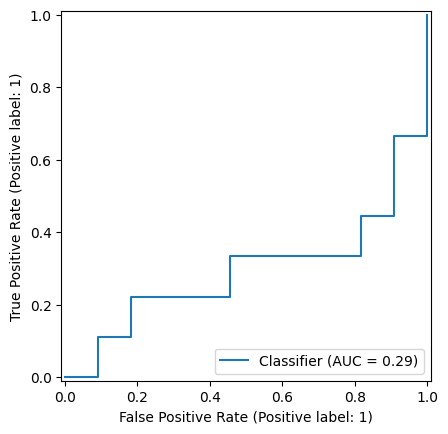

In [106]:

fname = next((fdir_external / organ / 'reg').glob("*processed.h5"))
fname = fname.name

data_eval = pd.read_hdf(fdir_external / organ / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / organ / 'reg' / 'SraRunTable.txt', sep=',')
# data_eval_header = data_eval_header.loc(data_eval.index)
# print(data_eval_header.columns)
# print('ground true: ', (data_eval_header['sex'].values == 'male').astype(int))

features_fname = f"geuvadis_train_features_{sex}_calibration_{organ}.csv"
features_list = pd.read_csv(ml_models_fdir / model_type / features_fname, index_col=0)

data_eval = data_eval[features_list.index]

X_eval = data_eval.values
y_eval = data_eval_header['sex'].replace(
    {"female": "F", 'male': "M"}
).values
print(y_eval)

label_encoder = LabelEncoder().fit(y_eval)
y_eval = label_encoder.transform(y_eval)

scaler = RobustScaler().fit(X_eval)
X_eval = scaler.transform(X_eval)

# X_eval = RobustScaler().fit_transform(X_eval)

proba = np.zeros(shape=(X_eval.shape[0], 2))
pred = np.zeros(shape=(X_eval.shape[0]))

mean_fpr = np.linspace(0, 1, 100)
tprs = []
accuracies = []
f1 = []
precisions = []
recalls = []

for i in range(1):
    # saved_model_filename = f"geuvadis_fold{i}_{sex}_calibration_{organ}.json"
    # model.load_model(fname=ml_models_fdir / model_type / saved_model_filename)

    proba += model.predict_proba(X_eval)
    pred_ = model.predict(X_eval)
    # if sex == 'autosome':
    #     pred_ = np.abs(pred_ - 1)
    pred += pred_

    accuracies.append(accuracy_score(y_eval, pred_))
    f1.append(f1_score(y_eval, pred_))
    precisions.append(precision_score(y_eval, pred_))
    recalls.append(recall_score(y_eval, pred_))

    viz = RocCurveDisplay.from_predictions(
        y_eval, model.predict_proba(X_eval)[:, 1], ax=None
        # ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0
    tprs.append(interp_tpr)
    
proba = proba / 5
# # pred = pred / 5
# if sex == 'autosome':
#     print('predicted:   ', (proba[:, 1] > 0.5).astype(int))
# else:
#     print('predicted:   ', (proba[:, 1] > 0.5).astype(int))
# # print(pred.astype(int))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0

mean_auc = auc(mean_fpr, mean_tpr)
mean_accuracy = np.mean(accuracies)
mean_f1 = np.mean(f1)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

print("-" * 20)
print(f"{mean_auc=},")
print(f"{mean_accuracy=},")
print(f"{mean_f1=},")
print(f"{mean_precision=},")
print(f"{mean_recall=},")
print("-" * 20)
print('```')

print(features_list)

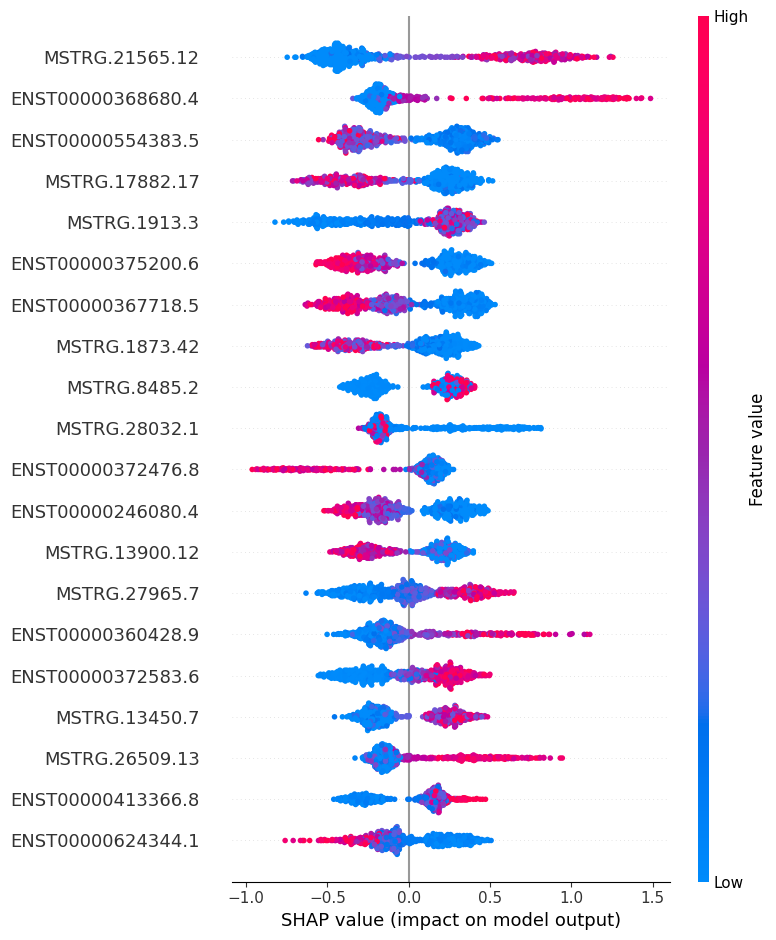

In [107]:
X_train = pd.DataFrame(data=X_train, columns=data.columns)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=data.columns,)

# xgboost.plot_importance(model, importance_type="cover")
# shap.dependence_plot('MSTRG.36020.14', shap_values, X_train)

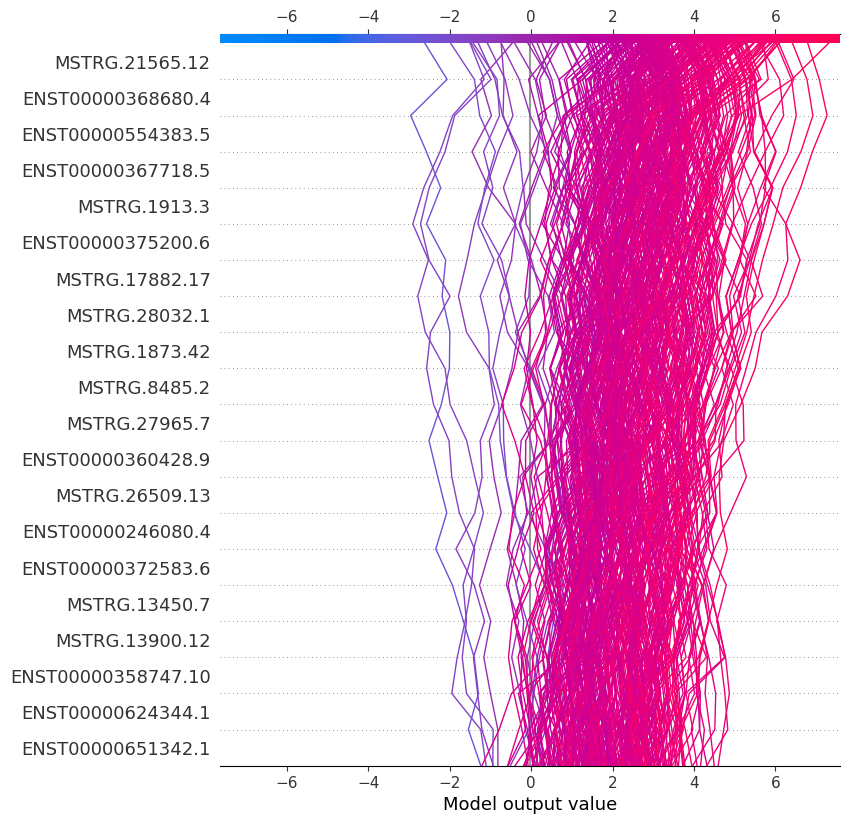

In [108]:
shap.decision_plot(explainer.expected_value, shap_values[y_train==1], X_train)
# shap.force_plot(explainer.expected_value, shap_values, X_train)


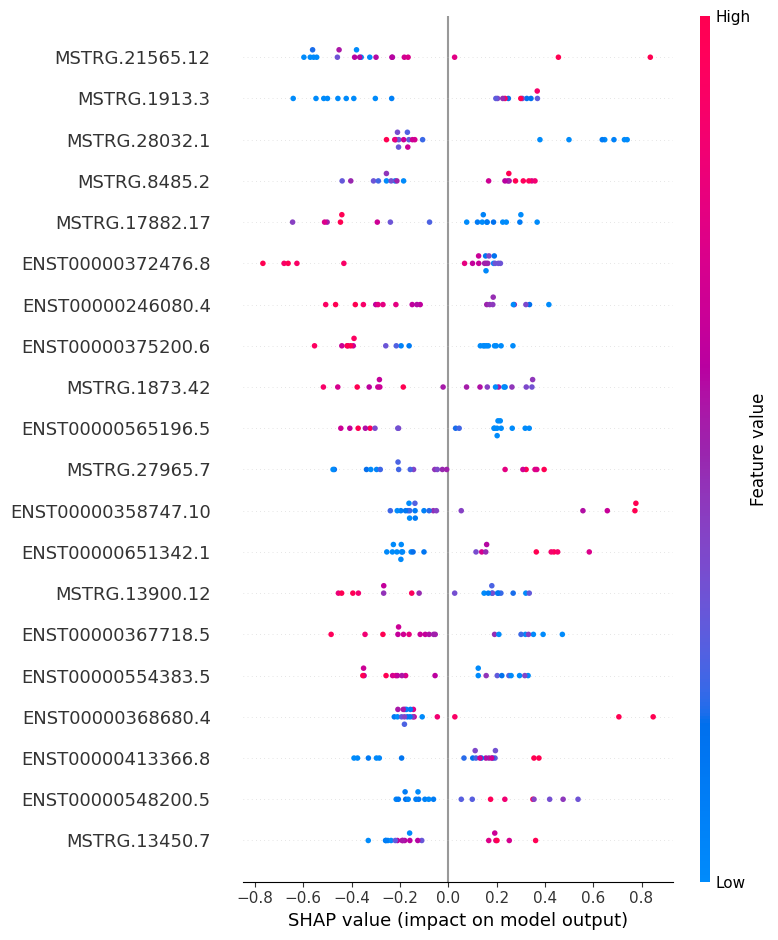

In [109]:
X_eval = pd.DataFrame(data=X_eval, columns=data_eval.columns)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_eval)
shap.summary_plot(shap_values, X_eval, feature_names=data_eval.columns,)
# xgboost.plot_importance(model, importance_type="cover")
# shap.dependence_plot('MSTRG.36020.14', shap_values, X_eval)

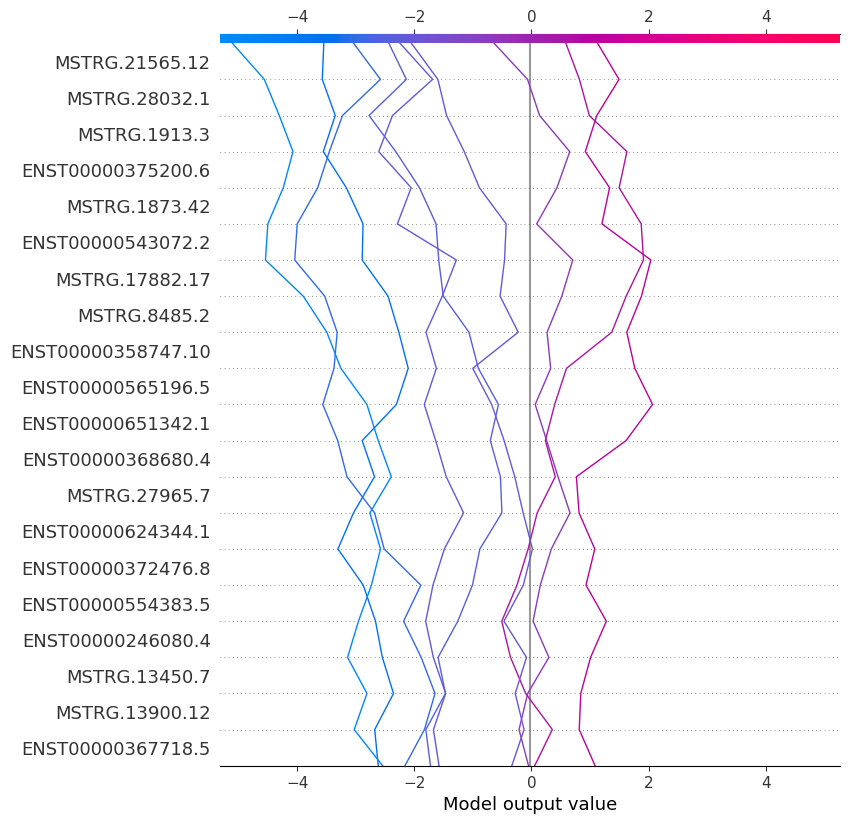

In [110]:
shap.decision_plot(explainer.expected_value, shap_values[y_eval==1], X_eval)
# shap.force_plot(explainer.expected_value, shap_values, X_eval)


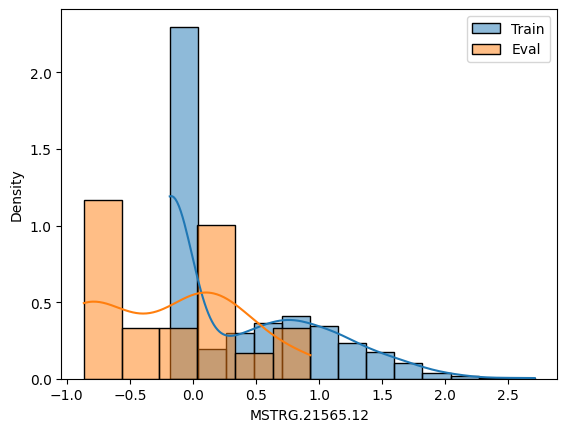

In [111]:
sns.histplot(
    X_train['MSTRG.21565.12'], kde=True, stat='density', label='Train'
    # data['MSTRG.35413.93'], kde=True, stat='density'
)
sns.histplot(
    X_eval['MSTRG.21565.12'], kde=True, stat='density', label='Eval'
    # data_eval['MSTRG.35413.93'], kde=True, stat='density'
)
plt.legend()

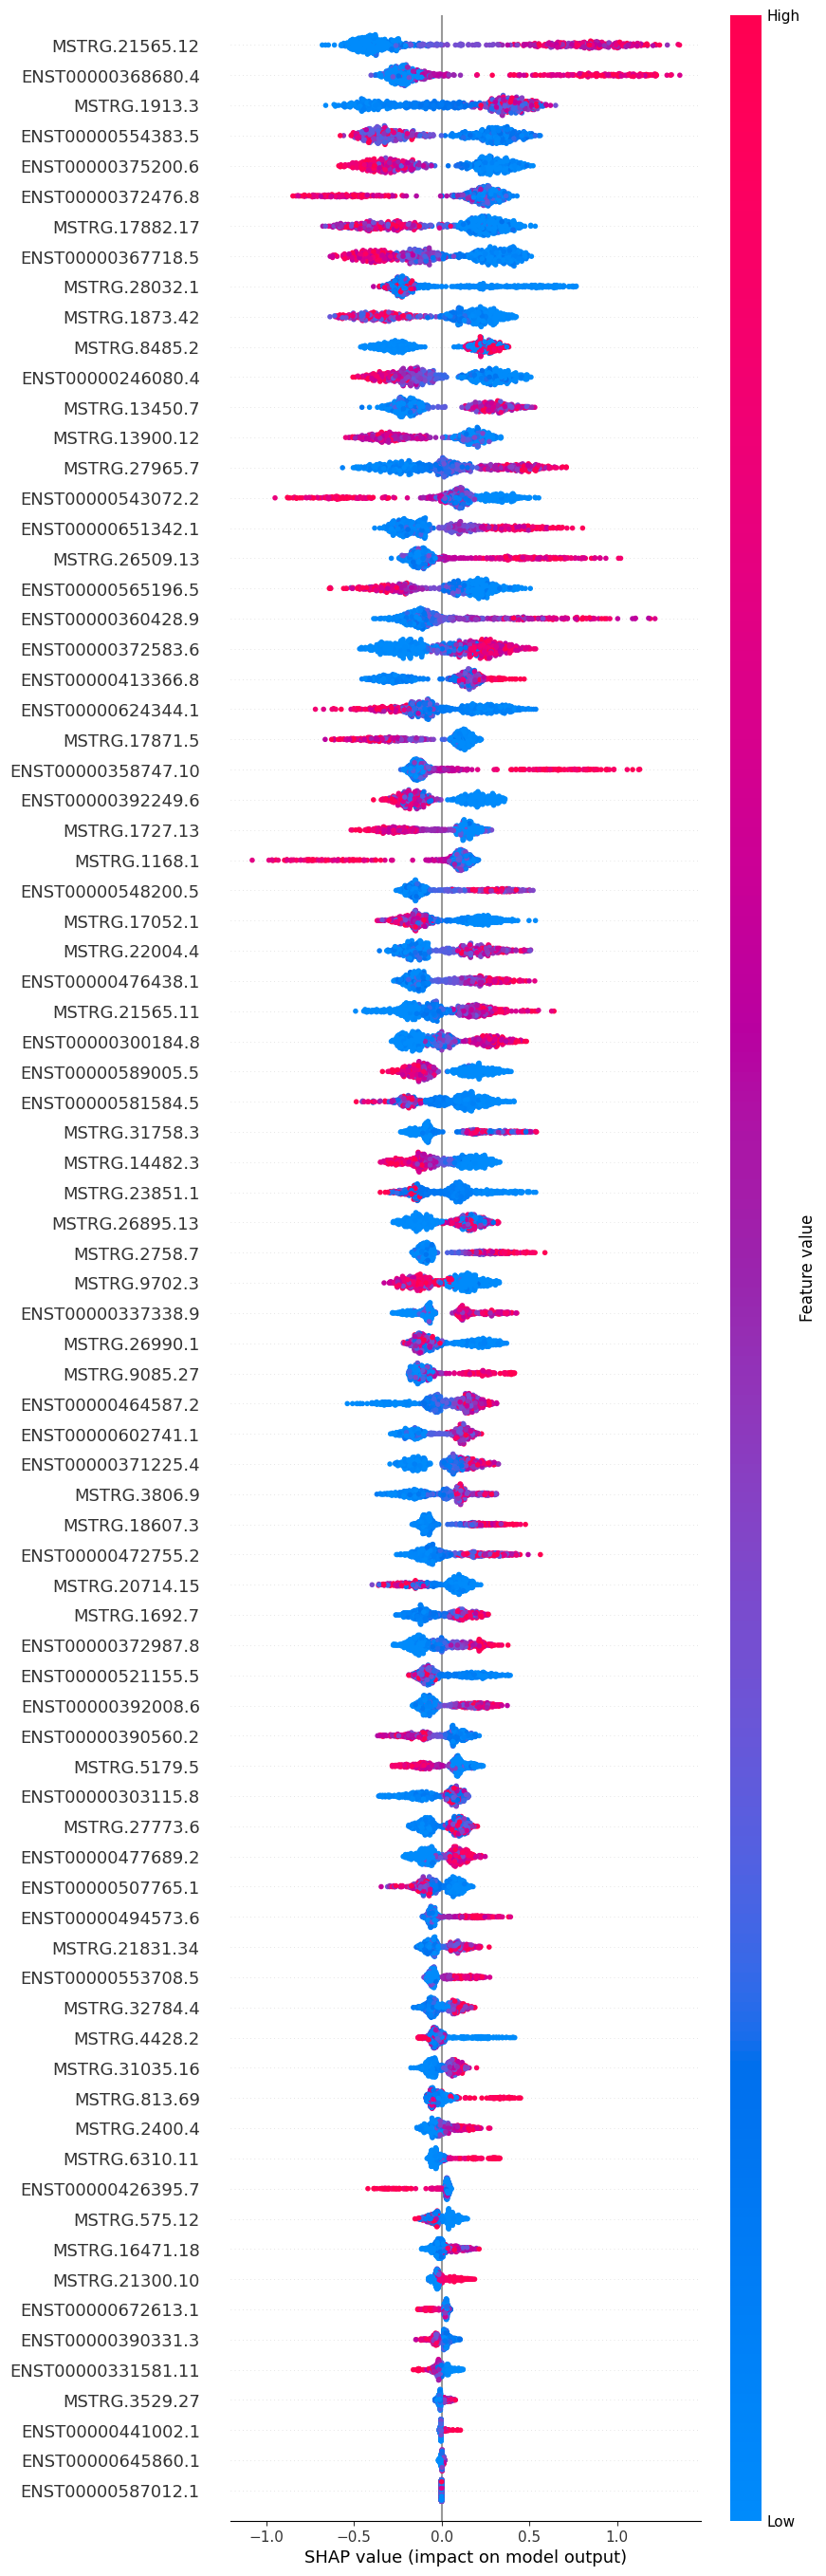

In [112]:
explainer_train = shap.Explainer(model, X_train)
shap_values_train = explainer_train(X_train)
shap.plots.beeswarm(shap_values_train, order=shap_values_train.abs.mean(0), max_display=X_train.shape[1])

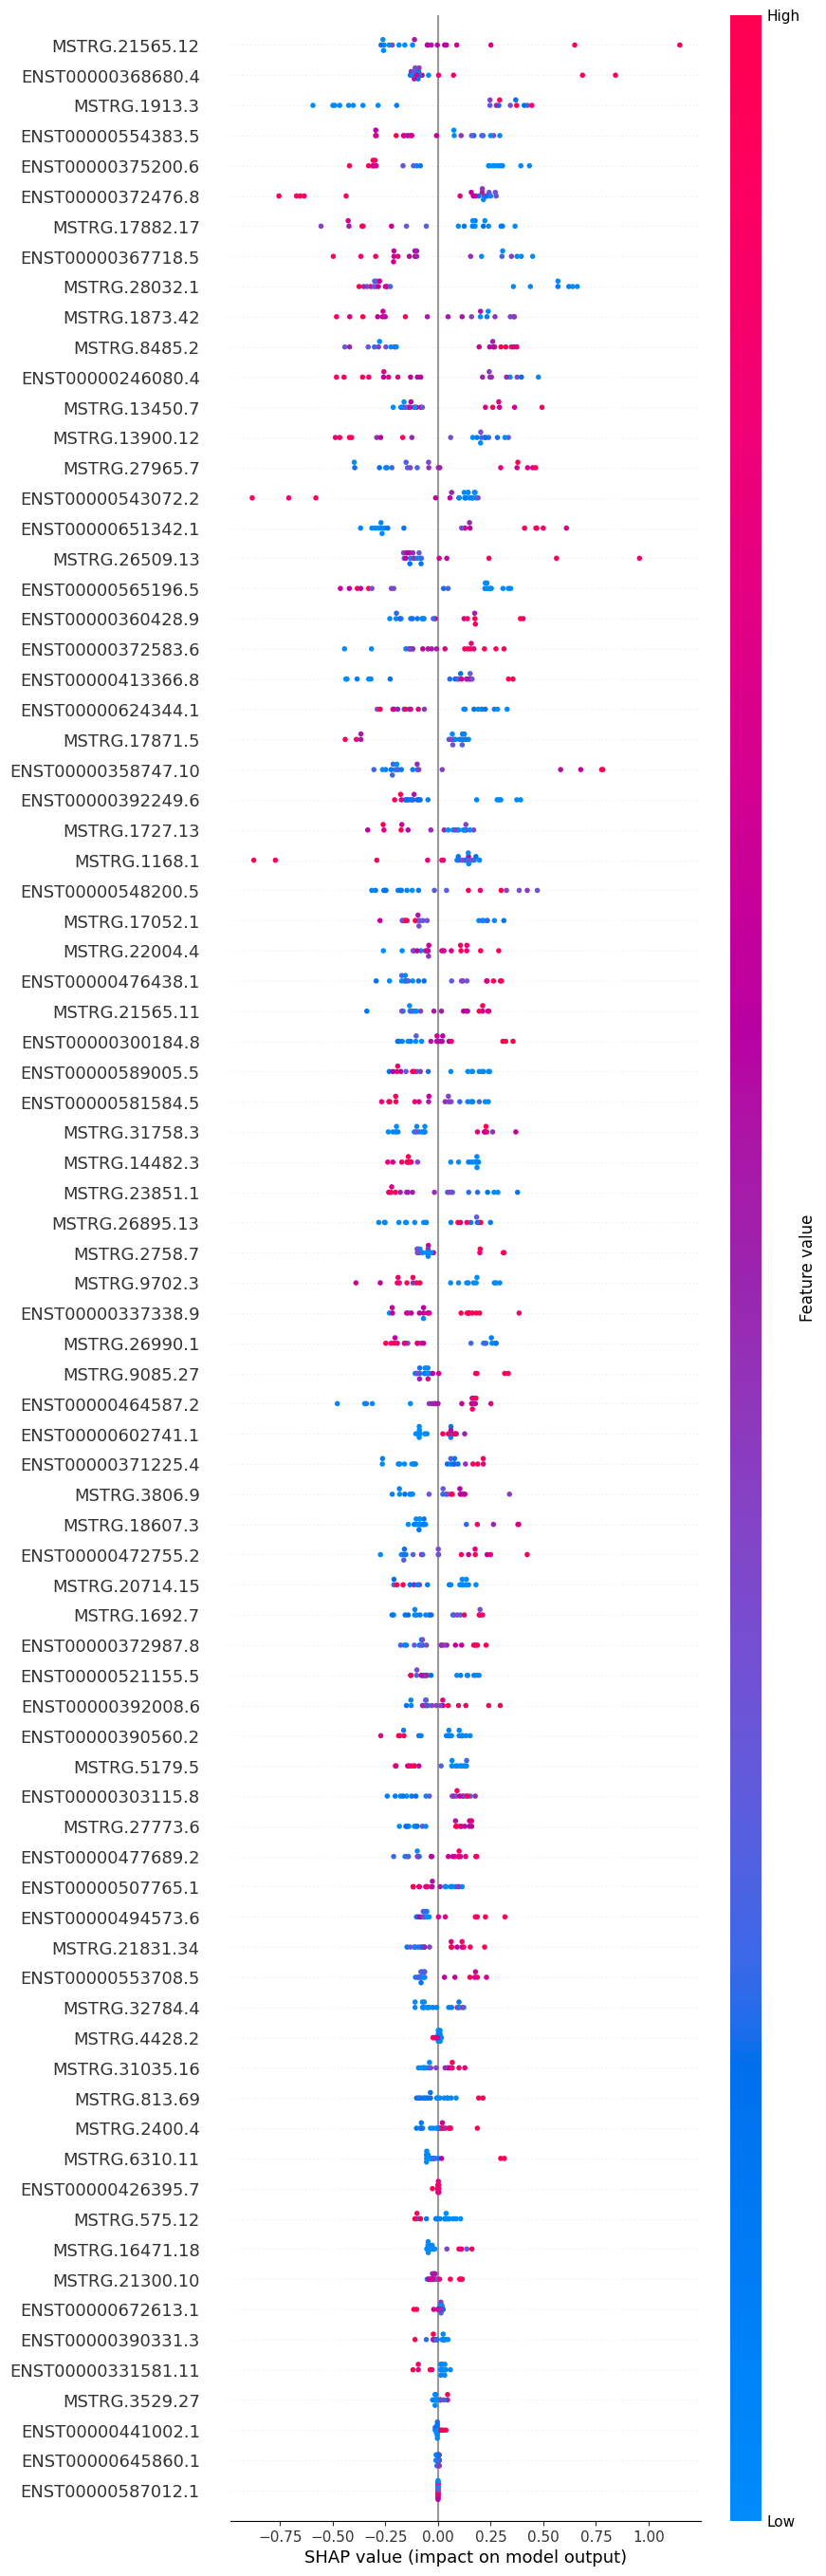

In [113]:
explainer = shap.Explainer(model, X_eval)
shap_values_eval = explainer(X_eval)
shap.plots.beeswarm(shap_values_eval, order=shap_values_train.abs.mean(0), 
                    max_display=X_eval.shape[1])

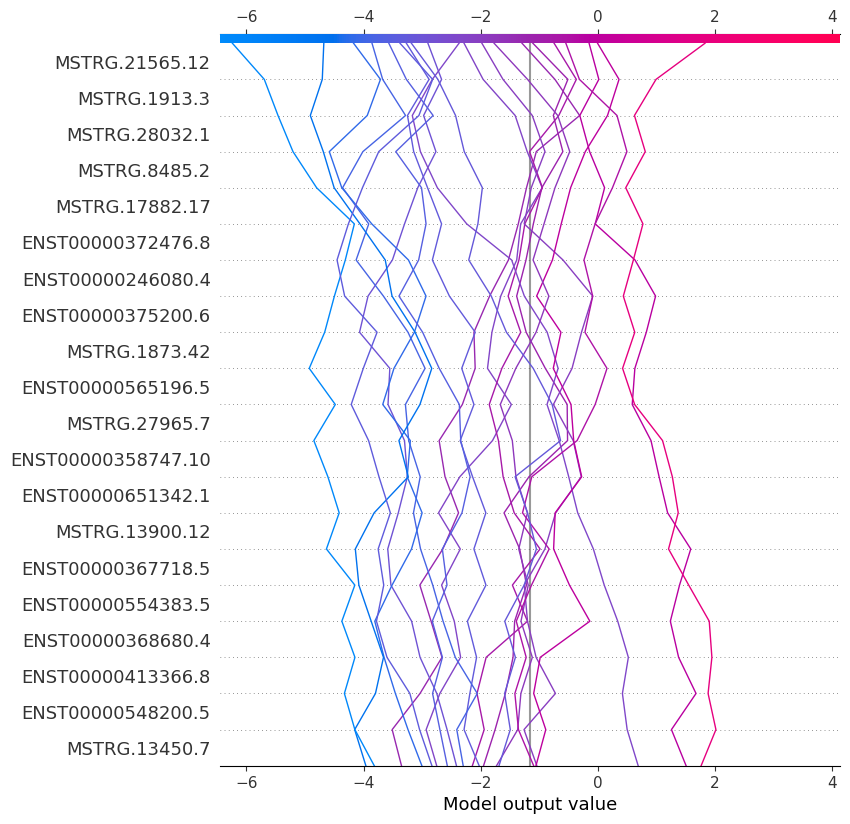

In [114]:
shap.decision_plot(explainer.expected_value, shap_values, X_eval)
